In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load Dataset
data = pd.read_csv('sepsis.csv')

In [ ]:
# Preprocess the Data
if 'ICULOS' in data.columns:
    data = data.drop(columns=['ICULOS'])
data.fillna(data.mean(), inplace=True)

features = data.drop(columns=['SepsisLabel'])
labels = data['SepsisLabel']

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
def create_sequences(data, labels, seq_length=12):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = labels[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
X, y = create_sequences(features_scaled, labels.values)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# LSTM Model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Training
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stop])


Epoch 1/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.9690 - loss: 0.1437 - val_accuracy: 0.9781 - val_loss: 0.1003
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9769 - loss: 0.1057 - val_accuracy: 0.9781 - val_loss: 0.0954
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.9774 - loss: 0.1011 - val_accuracy: 0.9781 - val_loss: 0.0946
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.9775 - loss: 0.0970 - val_accuracy: 0.9781 - val_loss: 0.1031
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.9767 - loss: 0.1000 - val_accuracy: 0.9781 - val_loss: 0.0916
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9737 - loss: 0.1051 - val_accuracy: 0.9781 - val_loss: 0.0914
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9769 - loss: 0.0903 - val_accuracy: 0.9783 - val_loss: 0.0893
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9775 - loss: 0.0892 - 

In [ ]:
#Accuracy prediction
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9753 - loss: 0.0928

Test Accuracy: 0.9793


In [ ]:
# confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7606
           1       0.11      0.01      0.01       154

    accuracy                           0.98      7760
   macro avg       0.55      0.50      0.50      7760
weighted avg       0.96      0.98      0.97      7760



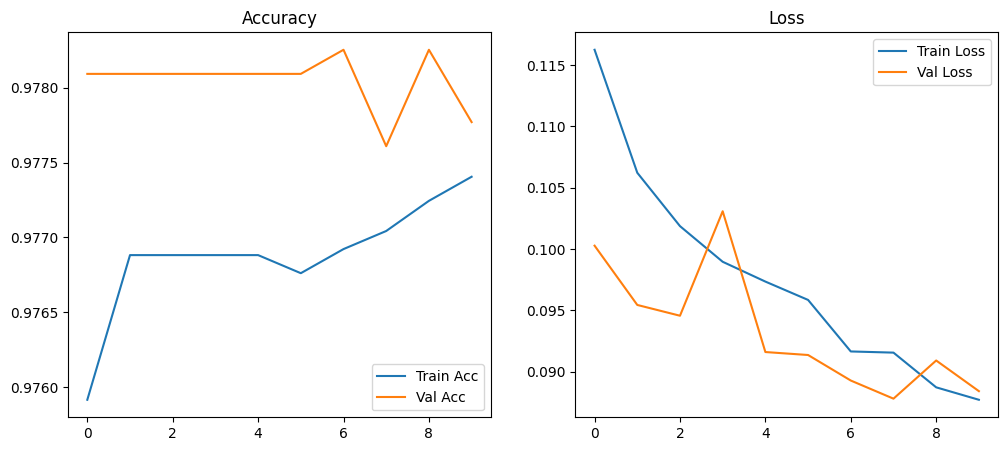

In [ ]:
# Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()

In [ ]:
#Saving
model.save("models/saved_model.h5")

In [ ]:
# Predict Sepsis on New Input Data
# run this if the data set is sepsis_sample.csv
new_input_data = {
    'HeartRate': [85],
    'SBP': [120],
    'DBP': [80],
    'SpO2': [95],
    'Temperature': [38.1]
}

new_input_df = pd.DataFrame(new_input_data)
# Normalize
new_input_scaled = scaler.transform(new_input_df)

sequence_length = 12
new_input_sequence = np.tile(new_input_scaled, (sequence_length, 1)).reshape(1, sequence_length, -1)
predicted_proba = model.predict(new_input_sequence)
predicted_label = 'Sepsis' if predicted_proba > 0.5 else 'No Sepsis'  #threshold is 0.5

print(f"Predicted Probability of Sepsis: {predicted_proba[0][0]:.4f}")
print(f"Prediction: {predicted_label}")


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- HeartRate
- SpO2
- Temperature
Feature names seen at fit time, yet now missing:
- AST
- Age
- Alkalinephos
- BUN
- BaseExcess
- ...


In [32]:
#Predict Sepsis on New Input Data
# run this if the  dataset is sepsis.csv

new_input_data = {
    'HR': [85],            # Heart Rate
    'O2Sat': [95],         # Oxygen Saturation
    'Temp': [38.1],        # Temperature (Celsius)
    'SBP': [120],          # Systolic Blood Pressure
    'MAP': [90],           # Mean Arterial Pressure
    'DBP': [80],           # Diastolic Blood Pressure
    'Resp': [18],          # Respiration rate
    'EtCO2': [35],         # End-tidal CO2
    'BaseExcess': [2],     # Base excess
    'HCO3': [24],          # Bicarbonate
    'FiO2': [0.21],        # Fraction of inspired O2
    'pH': [7.38],          # Blood pH
    'PaCO2': [40],         # Partial Pressure of CO2
    'SaO2': [98],          # Arterial Oxygen Saturation
    'AST': [20],           # Aspartate Aminotransferase
    'BUN': [18],           # Blood Urea Nitrogen
    'Alkalinephos': [70],  # Alkaline Phosphatase
    'Calcium': [9.2],      # Serum Calcium
    'Chloride': [100],     # Serum Chloride
    'Creatinine': [1.0],   # Serum Creatinine
    'Bilirubin_direct': [0.2],  # Direct Bilirubin
    'Glucose': [90],       # Blood Glucose
    'Lactate': [1.5],      # Serum Lactate
    'Magnesium': [1.8],    # Magnesium
    'Phosphate': [3.5],    # Phosphate
    'Potassium': [4.2],    # Potassium
    'Bilirubin_total': [1.0],  # Total Bilirubin
    'TroponinI': [0.01],   # Cardiac Troponin I
    'Hct': [45],           # Hematocrit
    'Hgb': [14],           # Hemoglobin
    'PTT': [30],           # Partial Thromboplastin Time
    'WBC': [6.2],          # White Blood Cells
    'Fibrinogen': [300],   # Fibrinogen
    'Platelets': [250],    # Platelets count
    'Age': [65],           # Age
    'Gender': [1],         # Gender (1 for Male, 0 for Female)
    'Unit1': [1],          # Unit 1 (ICU unit)
    'Unit2': [0],          # Unit 2 (if applicable)
    'HospAdmTime': [12],   # Hospital Admission Time
}

# Convert the input data to DataFrame
new_input_df = pd.DataFrame(new_input_data)

# Normalize the input data using the same scaler fitted on training data
new_input_scaled = scaler.transform(new_input_df)

# Create sequence from the input data (as the LSTM model requires sequences)
# Since this is a single instance, we'll duplicate it to match the required sequence length (e.g., 12)
sequence_length = 12
new_input_sequence = np.tile(new_input_scaled, (sequence_length, 1)).reshape(1, sequence_length, -1)

# Predict using the trained model
predicted_proba = model.predict(new_input_sequence)  # Probability of sepsis

# If probability > 0.5, sepsis is predicted, else no sepsis
predicted_label = 'Sepsis' if predicted_proba > 0.5 else 'No Sepsis'

# Output the result
print(f"Predicted Probability of Sepsis: {predicted_proba[0][0]:.4f}")
print(f"Prediction: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Probability of Sepsis: 0.1093
Prediction: No Sepsis
